# Setup

In [1]:
# from typing import Literal, Type

import os

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models

# seed for reproducibility
torch.manual_seed(42)

device = torch.device("mps" if torch.mps.is_available() else "cpu")

root = '.'
data_dir = os.path.join(root, 'assets/asl_dataset')

# verify that the data is available
assert os.path.exists(data_dir), f"Data directory {data_dir} does not exist."

os.getcwd()

'/Users/carivs/Documents/My space/Projects/sign-language/sign-language-alphabet-recognition'

# Helpers

## Data preprocessor

In [2]:
class DataPreprocessor:
    def __init__(self,
                 data_dir:str,
                 transform:transforms.Compose=None,
                 resize_shape:tuple[int,int]=(224, 224),
                 train_ratio:float=0.7,
                 val_ratio:float=0.15,
                 test_ratio:float=0.15,
                 batch_size:int=32):
        """
        Initialize the DataPreprocessor.

        Args:
            data_dir (str): Path to the dataset directory.
            transform (torchvision.transforms.Compose): Transformations to apply to the images.
            resize_shape (tuple[int,int]): Shape to resize the input images to.
            train_ratio (float): Proportion of data to use for training.
            val_ratio (float): Proportion of data to use for validation.
            test_ratio (float): Proportion of data to use for testing.
            batch_size (int): Batch size for DataLoader.
        """
        assert train_ratio + val_ratio + test_ratio == 1.0, "Ratios must sum to 1."
        
        self.data_dir = data_dir
        self.transform = transform or transforms.Compose([
            transforms.Resize(resize_shape),
            transforms.ToTensor(),
            transforms.Normalize((0,),(1,))
        ])
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio
        self.test_ratio = test_ratio
        self.batch_size = batch_size

    def preprocess(self) -> tuple[DataLoader, DataLoader, DataLoader]:
        """
        Process the data into train, validation, and test splits.

        Returns:
            tuple: DataLoader objects for train, validation, and test sets.
        """
        # Load the entire dataset
        full_dataset = datasets.ImageFolder(self.data_dir, transform=self.transform)
        
        # Compute dataset sizes
        total_size = len(full_dataset)
        train_size = int(self.train_ratio * total_size)
        val_size = int(self.val_ratio * total_size)
        test_size = total_size - train_size - val_size

        # Split the dataset indices
        indices = list(range(total_size))
        train_indices, temp_indices = train_test_split(indices, test_size=(val_size + test_size), random_state=42)
        val_indices, test_indices = train_test_split(temp_indices, test_size=test_size, random_state=42)

        # Create subsets
        train_dataset = Subset(full_dataset, train_indices)
        val_dataset = Subset(full_dataset, val_indices)
        test_dataset = Subset(full_dataset, test_indices)

        # Create DataLoaders
        train = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        test = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

        return train, val, test

## CNN Sign language classifier model

In [3]:
class SignLanguageCNN(nn.Module):
    """
    Convolutional Neural Network for Sign Language Recognition.
    """
    def __init__(self, num_classes:int):
        """
        Initialize the SignLanguageCNN.

        Args:
            num_classes (int): Number of classes in the dataset.
        """
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(16),
            nn.Dropout(0.5),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.Dropout(0.5),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.Dropout(0.5),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.Dropout(0.5)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 14 * 14, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.fc(x)
        return x


In [4]:
class SignLanguageTL(nn.Module):
    def __init__(self, model:nn.Module, weights:models.WeightsEnum, num_classes:int):
        super().__init__()
        """
        Initialize the ResNet model for fine-tuning.

        Args:
            num_classes (int): Number of output classes.
        """
        self.model = model(weights=weights)

        # Freeze all layers
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Unfreeze the parameters of the last few layers for fine-tuning
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        # Replace the fully connected layer
        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(in_features, 196),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(196, num_classes)
        )
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.model(x)
        return x

## Transfer learning Sign language classifeer model

In [5]:
class SignLanguageModel:
    def __init__(self,
                 model:nn.Module,
                 save_path:str=None,
                 device:torch.device=torch.device("cpu")):
        """
        Initialize the ResNet model for fine-tuning.

        Args:
            model (nn.Module): The ResNet model.
            save_path (str): Path to save the model.
            device (torch.device): Device to run the model on.
        """
        self.model = model.to(device)
        self.save_path = save_path
        self.device = device

    def train(self,
              train:DataLoader,
              val:DataLoader,
              criterion:nn.modules.loss._Loss,
              optimizer:optim.Optimizer,
              epochs:int=10,
              save_best:bool=False
    ) -> tuple[list[float], list[float]]:
        """
        Train the model.

        Args:
            train (DataLoader): Training data loader.
            val (DataLoader): Validation data loader.
            criterion (_Loss): Loss function.
            epochs (int): Number of training epochs.
            save_best (bool): Save the best model.
            
        Returns:
            tuple[list[float], list[float]]: Training and validation losses.
        """
        assert save_best and self.save_path or not save_best, "Save path must be provided if save_best is True."

        train_losses, val_losses = [], []
        best_val_loss = float('inf')  # Track the best validation loss
        
        for epoch in range(epochs):
            self.model.train()
            train_loss = 0.0
            for inputs, labels in train:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                
            train_loss /= len(train)
            val_loss = self.evaluate(val, criterion, is_test=False)
            
            # Save losses
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
            
            if save_best and val_loss < best_val_loss:
                best_val_loss = val_loss
                self.save_model(self.save_path)
                print(f"New best model saved with loss: {best_val_loss:.4f}")

        if save_best:
            self.load_model()
        
        return train_losses, val_losses

    def evaluate(self, val:DataLoader, criterion:nn.modules.loss._Loss=None, is_test:bool=False) -> float:
        """
        Evaluate the model on validation data.

        Args:
            val (DataLoader): Validation data loader.
        """
        assert not is_test and criterion or is_test, "Criterion must be provided for evaluation."
        
        self.model.eval()
        correct = 0
        total = 0
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                if is_test:
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                else:
                    # loss = criterion(outputs, labels)
                    val_loss += criterion(outputs, labels).item()

        # print(f"Validation Accuracy: {100 * correct / total}%")
        return 100 * correct / total if is_test else val_loss / len(val)
    
    def load_model(self, path:str=None) -> None:
        """
        Load the model from a file. If no path is provided, the model is loaded from the save path.
        """
        assert path or self.save_path, "Save path must be provided to load the model."
        
        path = path or self.save_path
        self.model.load_state_dict(torch.load(path))
        
    def save_model(self, path:str=None) -> None:
        """
        Save the model to a file.
        """
        assert path or self.save_path, "Save path must be provided to save the model."
        
        torch.save(self.model.state_dict(), path or self.save_path)

# Execution

## Initialization

In [6]:
INPUT_SHAPE = (224, 224)
NB_CHANNELS = 3
TRAIN_RATIO, VAL_RATIO, TEST_RATIO = 0.7, 0.15, 0.15
LR = 0.001
save_path = {
    'cnn': os.path.join(root, 'models/sign_language_cnn.pth'),
    'tl': os.path.join(root, 'models/sign_language_tl.pth'),
    'vt': os.path.join(root, 'models/sign_language_vf.pth'),
}

weights = models.ResNet50_Weights.DEFAULT
transform = weights.transforms()

## Data preprocessing

In [7]:
data_preprocessor = DataPreprocessor(data_dir,
                                     transform=transform,
                                     resize_shape=INPUT_SHAPE,
                                     train_ratio=TRAIN_RATIO,
                                     val_ratio=VAL_RATIO,
                                     test_ratio=TEST_RATIO)
train, val, test = data_preprocessor.preprocess()

# Print class names and sizes
classes = datasets.ImageFolder(data_dir).classes
num_classes = len(classes)
print(f"Classes: {classes}")
print(f"Train size: {len(train.dataset)}")
print(f"Validation size: {len(val.dataset)}")
print(f"Test size: {len(test.dataset)}")

Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Train size: 1760
Validation size: 377
Test size: 378


## Training

In [8]:
from src.trainer import SignLanguageModelTrainer

In [9]:
# Initialize the model
model_type = 'tl' # 'cnn' or 'tl' or 'vt'
model = SignLanguageCNN(num_classes=num_classes) if model_type == 'cnn' \
    else SignLanguageTL(models.resnet50, weights, num_classes=num_classes)

criterion = nn.CrossEntropyLoss()  # Suitable for classification
optimizer = optim.Adam(model.parameters(), lr=LR)
# optimizer = optim.SGD(model.parameters(), lr=LR*5, momentum=0.9)

trainer = SignLanguageModelTrainer(model, classes, save_path=save_path[model_type], device=device)
# summary(model, (NB_CHANNELS, *INPUT_SHAPE))#, device=device.type)

In [10]:
# Train the model
train_losses, val_losses = trainer.train(train, val, criterion, optimizer, epochs=20, save_best=True)

Epoch 1/20, Train Loss: 1.9904, Val Loss: 0.5223
New best model saved with loss: 0.5223
Epoch 2/20, Train Loss: 0.4401, Val Loss: 0.3436
New best model saved with loss: 0.3436
Epoch 3/20, Train Loss: 0.2615, Val Loss: 0.5556
Epoch 4/20, Train Loss: 0.1798, Val Loss: 0.3272
New best model saved with loss: 0.3272
Epoch 5/20, Train Loss: 0.1202, Val Loss: 0.1753
New best model saved with loss: 0.1753
Epoch 6/20, Train Loss: 0.1068, Val Loss: 0.1504
New best model saved with loss: 0.1504
Epoch 7/20, Train Loss: 0.0489, Val Loss: 0.1728
Epoch 8/20, Train Loss: 0.0154, Val Loss: 0.0997
New best model saved with loss: 0.0997
Epoch 9/20, Train Loss: 0.0111, Val Loss: 0.1713
Epoch 10/20, Train Loss: 0.0278, Val Loss: 0.1266
Epoch 11/20, Train Loss: 0.0095, Val Loss: 0.0979
New best model saved with loss: 0.0979
Epoch 12/20, Train Loss: 0.0250, Val Loss: 0.2151
Epoch 13/20, Train Loss: 0.0426, Val Loss: 0.2228
Epoch 14/20, Train Loss: 0.0515, Val Loss: 0.1941
Epoch 15/20, Train Loss: 0.0493, Val

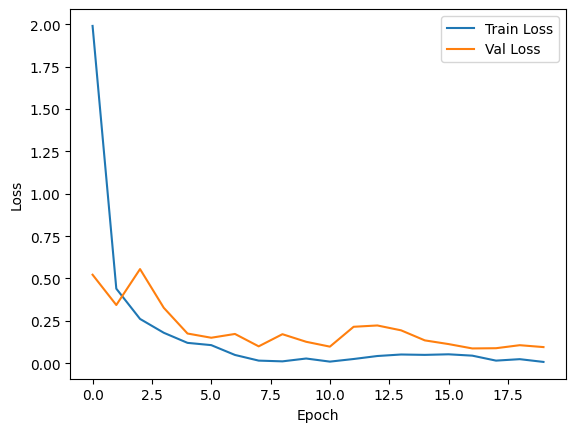

In [11]:
# Plot the training and validation losses
trainer.plot_losses(train_losses, val_losses)

## Testing

In [10]:
# Evaluate
trainer.load_model()
acc, y_true, y_pred = trainer.evaluate(test, is_test=True)
acc

97.35449735449735

AttributeError: Axes.set() got an unexpected keyword argument 'font_size'

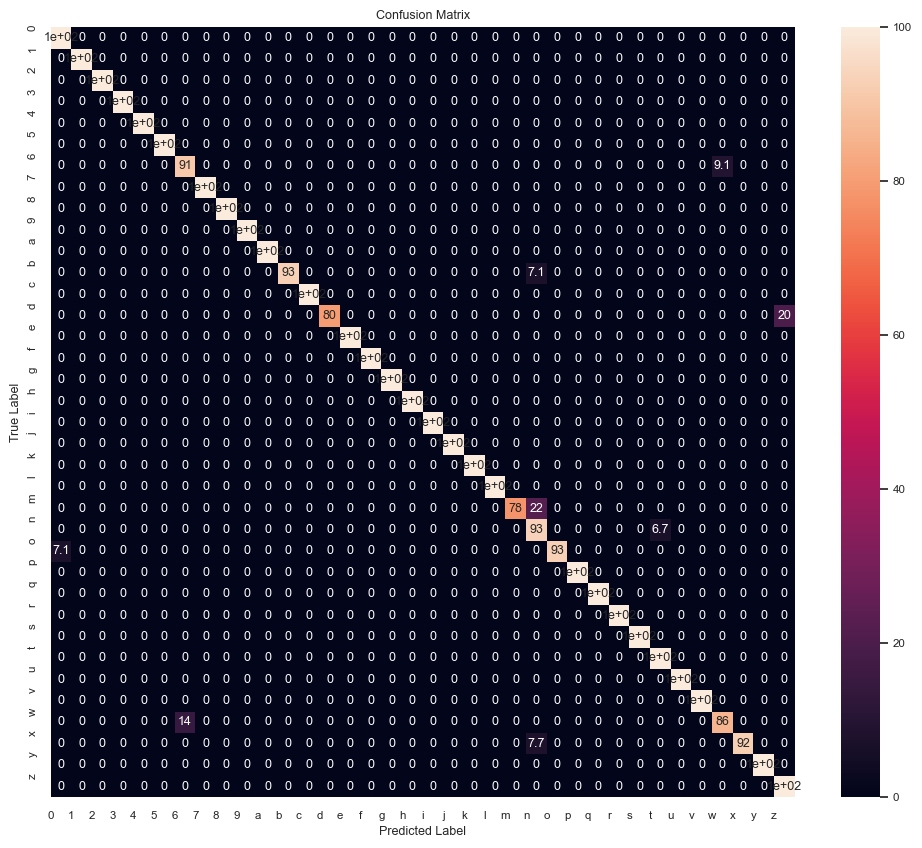

In [11]:
sns.set_theme(font_scale=0.75)
figsize = (12, 10)
trainer.plot_confusion_matrix(y_true, y_pred, classes, figsize=figsize, normalize=True)